# Assignment 2

In [51]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal
import ncc
import matplotlib.pyplot as plt

## Part 1: Face Detection in a Scaled Representation

### Question 2

In [52]:
def make_pyramid(image, minsize):
    # initial image and dimensions
    pyramid = [image]
    width, height = image.size
    
    # while both h,w are larger than minsize
    while height >= minsize and width >= minsize:
        # resize image w/ 0.75 scale using bicubic interpolation
        dim = (int(width*0.75), int(height*0.75))
        image = image.resize(dim, Image.BICUBIC)
        # update new height and width
        width, height = image.size
        # add resized image to pyramid
        pyramid.append(image)
        
    return pyramid

### Question 3

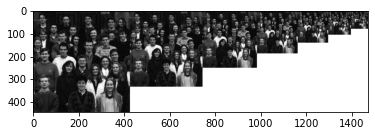

In [93]:
def show_pyramid(pyramid):
    # set height and width of pyramid image
    height = pyramid[0].size[1]
    widths = []
    for img in pyramid:
        widths.append(img.size[0])
    collage = Image.new("L", (sum(widths), height), 255)
    
    for idx,img in enumerate(pyramid):
        # offset by sum of prev widths
        offset_x = sum(widths[:idx])
        # paste imgs to pyramid img
        collage.paste(img, (offset_x, 0))
    
    # show the pyramid image 
    plt.imshow(collage, cmap="gray")
    plt.show()

image = Image.open("faces/students.jpg")
pyramid = make_pyramid(image, 100)
show_pyramid(pyramid)

### Question 4

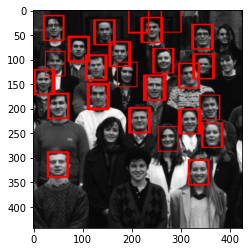

In [95]:
# create a template with new width, scaling height equivalently
def create_template(width):
    t = Image.open("faces/template.jpg")
    scale = width/t.width
    template = t.resize((int(t.width*scale), int(t.height*scale)), Image.BICUBIC)
    return template

def find_template(pyramid, template, threshold):
    face_points = []
    for idx,img in enumerate(pyramid):
        # normalized corss correlation on image and face-template
        ncc_array = ncc.normxcorr2D(img, template)
        # iterate through pixles
        for x in range(img.width):
            for y in range(img.height):
                # check its value against the threshold
                if ncc_array[y][x] > threshold:
                    # append to face_points if above given threshold
                    face_points.append((x/(0.75**idx), y/(0.75**idx)))
    
    # draw bounding boxes on faces
    lg_img = pyramid[0]
    lg_img = lg_img.convert("RGB")
    for p in face_points:
        draw = ImageDraw.Draw(lg_img)
        x1 = p[0]-20
        x2 = p[0]+20
        y1 = p[1]-25
        y2 = p[1]+25
        draw.line((x1,y1,x1,y2),fill="red",width=2)
        draw.line((x2,y1,x2,y2),fill="red",width=2)
        draw.line((x1,y1,x2,y1),fill="red",width=2)
        draw.line((x1,y2,x2,y2),fill="red",width=2)
        del draw
    plt.imshow(lg_img)
    plt.show()

image = Image.open("faces/students.jpg")
pyramid = make_pyramid(image, 100)
template15 = create_template(15)
find_template(pyramid, template, 0.6)